In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import string
import re

from google.colab import drive

from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve, classification_report, recall_score, f1_score, accuracy_score, precision_score
from sklearn.multiclass import OneVsRestClassifier

import xgboost as xgb

from sklearn.utils import shuffle
import pickle

In [0]:
# setting fixed seed value for consistency in results
seed = 7
np.random.seed(seed)

In [0]:
# fetching train and test sets - https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data
# reuploaded on Drive for reproducability - https://drive.google.com/file/d/1K0o5SGAYtraa4p0h3qqIe3k1QjdUwJCW/view?usp=sharing

train_data = pd.read_csv('https://drive.google.com/uc?export=view&id=1K0o5SGAYtraa4p0h3qqIe3k1QjdUwJCW')
test_data = pd.read_csv('https://drive.google.com/uc?export=view&id=1kYR1n0runN4MujEo7JN8I0UGLFMRh6aZ')

In [51]:
train_data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


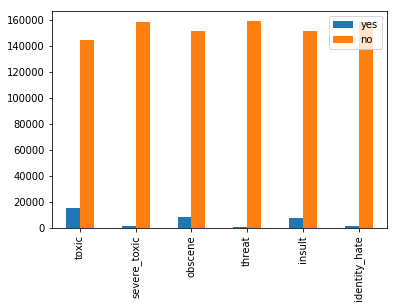

In [52]:
# some EDA to understand the labels

toxic_labels = ['toxic', 'severe_toxic',	'obscene',	'threat',	'insult',	'identity_hate']

negative_vals = [
train_data.toxic.value_counts()[0],
train_data.severe_toxic.value_counts()[0],
train_data.obscene.value_counts()[0],
train_data.threat.value_counts()[0],
train_data.insult.value_counts()[0],
train_data.identity_hate.value_counts()[0] ]

positive_vals = [
train_data.toxic.value_counts()[1],
train_data.severe_toxic.value_counts()[1],
train_data.obscene.value_counts()[1],
train_data.threat.value_counts()[1],
train_data.insult.value_counts()[1],
train_data.identity_hate.value_counts()[1] ]

plot_df = pd.DataFrame({'yes': positive_vals,
                       'no': negative_vals},
                      index = toxic_labels)

plot_df.plot.bar()

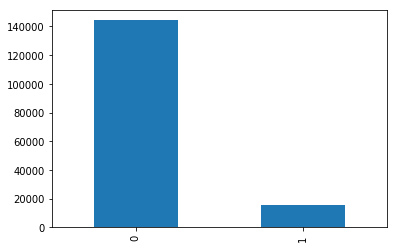

In [53]:
# let's check the distribution of positive and negative comments

train_temp = train_data
train_temp['clean'] = 1 - train_temp[toxic_labels].max(axis = 1)
train_temp.toxic.value_counts().plot.bar()

In [0]:
# Above EDA proves the dataset is imbalanced, simple classifiers won't work without sampling. 
# We'll test two things - XGB with OvR and a gradient booster (XGB?) with log-count ratios 

# Cleaning up missing or corrupt comments (fill unknowns with NAs). 
train_data.loc[train_data['comment_text'] == "unknown"]

# no missing comments found, so no replacements needed
# train_data["comment_text"].fillna("unknown", inplace = True)

# let's prepare our data (making a TF-IDF matrix with term frequencies)
# we test unigrams and bigrams 'not bitch' is not toxic even if 'bitch' is."
tf_idf_mat = TfidfVectorizer(ngram_range=(1,2),
                             use_idf=1,
                             stop_words = 'english',
                             strip_accents = 'unicode')

# predictor-feature split
X = train_data.iloc[:, 1]
y = train_data.iloc[:, 2:]
y.head()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

# combining X_train and y_train to create the TF-IDF matrix for training
train_split  = pd.concat([X_train, y_train], 
                         axis=1)

train_tf_mat = tf_idf_mat.fit_transform(X_train)
test_tf_mat = tf_idf_mat.fit_transform(X_test)

In [66]:
print(train_tf_mat[0])

  (0, 86295)	0.07444152478542622
  (0, 1045602)	0.11396166020971087
  (0, 1995285)	0.07465972912991375
  (0, 75073)	0.16887969997755656
  (0, 148339)	0.10675432774183133
  (0, 2009417)	0.06417416821931339
  (0, 1934190)	0.09394964456595904
  (0, 820666)	0.06275221956304418
  (0, 456934)	0.1668995350038174
  (0, 505911)	0.11424342559145813
  (0, 645501)	0.16398797509084864
  (0, 1404705)	0.14828637982566675
  (0, 1177046)	0.16507568375997722
  (0, 1120803)	0.211184213577669
  (0, 1151835)	0.06233375633304585
  (0, 1269070)	0.0675373697472907
  (0, 1780337)	0.08584084809780054
  (0, 988156)	0.08402129851464331
  (0, 628567)	0.06644637253166047
  (0, 87250)	0.14976056346522534
  (0, 1049519)	0.17486253576002658
  (0, 1995319)	0.15515594159407953
  (0, 75155)	0.1952607534646183
  (0, 148699)	0.1903867218232932
  (0, 2011056)	0.1361934457100893
  (0, 1934445)	0.18660612916976446
  (0, 821054)	0.20213031523303107
  (0, 456937)	0.20213031523303107
  (0, 505983)	0.20213031523303107
  (0, 64551

In [0]:
xgb_params = {
    'n_estimators': 200,
    'eta': 0.1,
    'objective': 'multi:softmax',
    'seed': 7
}

boost = xgb.XGBClassifier(max_depth = 8,
                         n_estimators = 200,
                         objective = 'multi:softmax',
                         seed = 7,
                         num_class = 6)

ovr = OneVsRestClassifier(boost, n_jobs = -1)

ovr.fit(train_tf_mat.tocsc(), y_train)

In [0]:
ovr